In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

In [2]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_total = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [3]:
df_acc_total.shape

(856, 258)

In [4]:
df1 = df_acc_total[["mergeid", "GGIR_mean_ENMO_total", "OxCGRT_stay_at_home", "OxCGRT_stringency_index", "country"]].copy()
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [5]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [6]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [7]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

df = map_bmi_num(df)
df = df.drop(df.loc[df['bmi'] < 15].index)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

df.loc[:, 'OxCGRT_stay_at_home'] = df['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})
df.shape

(842, 15)

In [8]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [9]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [10]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

Total

In [11]:
df['disease'].value_counts()

control    379
d1         238
d4          65
d3          47
d5          46
d2          44
d7          17
d6           6
Name: disease, dtype: int64

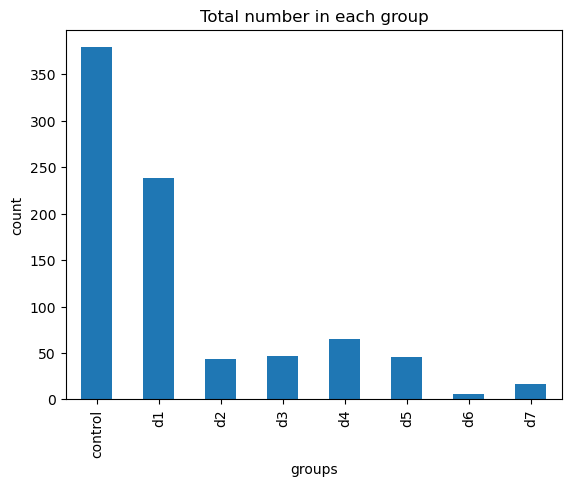

In [12]:
disease_table = pd.crosstab(index=df['disease'], columns='count')
#labels = ["control", "Hypertension", "Diabetes", "OA", "Hyp_Dia", "Hyp_OA", "Dia_OA", "Hyp_Dia_OA"]
disease_table.plot(
    kind='bar', 
    title="Total number in each group", 
    ylabel="count",
    xlabel= "groups",
    #xticks=labels,
    legend=False
    )
plt.savefig(f'{dir_plots}Total count per group')

Sex

In [13]:
df['female'].value_counts()

1    490
0    352
Name: female, dtype: int64

In [14]:
c_sex = df.groupby('disease')['female'].value_counts().astype(int)
#count occurrence of each value in 'female' column per disease-group as percentage of total
p_sex = df.groupby('disease')['female'].value_counts(normalize=True).mul(100).round(1).astype(str) 
count_sex = pd.concat([c_sex,p_sex],keys=['counts','%']).unstack()
count_sex.T

counts                                   %                          \
disease control   d1  d2  d3  d4  d5 d6  d7 control    d1    d2    d3    d4   
female                                                                        
0           161  105  20  12  35  10  2   7    42.5  44.1  45.5  25.5  53.8   
1           218  133  24  35  30  36  4  10    57.5  55.9  54.5  74.5  46.2   

                           
disease    d5    d6    d7  
female                     
0        21.7  33.3  41.2  
1        78.3  66.7  58.8

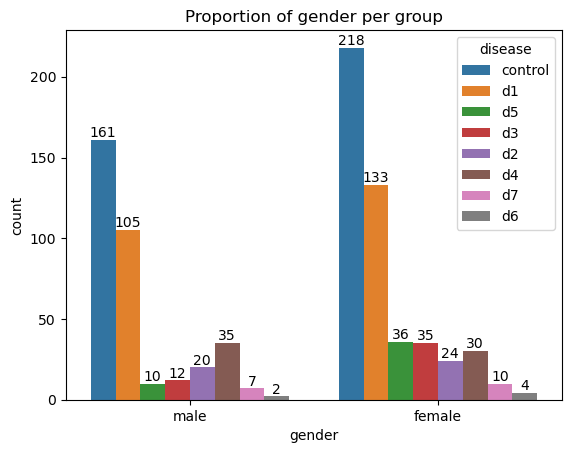

In [15]:
data = pd.DataFrame({
    "gender": df["female"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, x="gender", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(["male", "female"])
plt.title("Proportion of gender per group")
plt.savefig(f'{dir_plots}distribution gender (bar plot)')

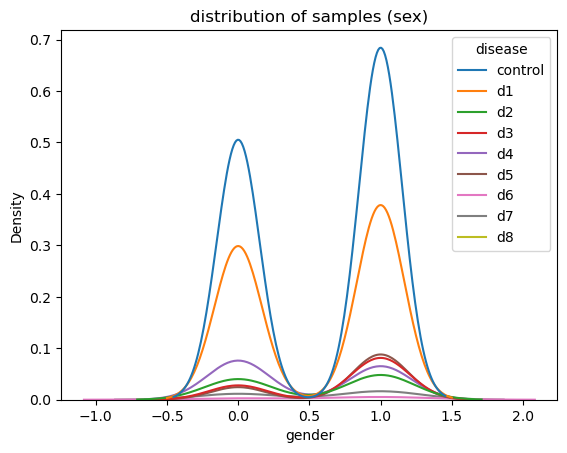

In [16]:
sns.kdeplot(data=df, x='female', hue='disease', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.title("distribution of samples (sex)")
plt.xlabel("gender")
plt.savefig(f'{dir_plots}KDE plot distribution sex')

Age

In [17]:
df['age'].agg(['min', 'max'])

min    50.599998
max    97.199997
Name: age, dtype: float64

In [18]:
st_dev_age = df.groupby('disease')['age'].agg(['mean', 'std', 'min', 'max']) 
st_dev_age

,mean,std,min,max
disease,,,,
control,66.876781,8.533324,50.700001,97.199997
d1,70.765126,9.349515,50.599998,94.300003
d2,70.270455,8.690374,52.599998,94.599998
d3,69.802128,9.558254,56.799999,91.900002
d4,71.424616,7.166394,57.299999,85.800003
d5,70.734783,8.596956,53.799999,90.800003
d6,72.516667,7.085878,59.799999,79.099998
d7,71.517647,8.207560,55.799999,87.599998


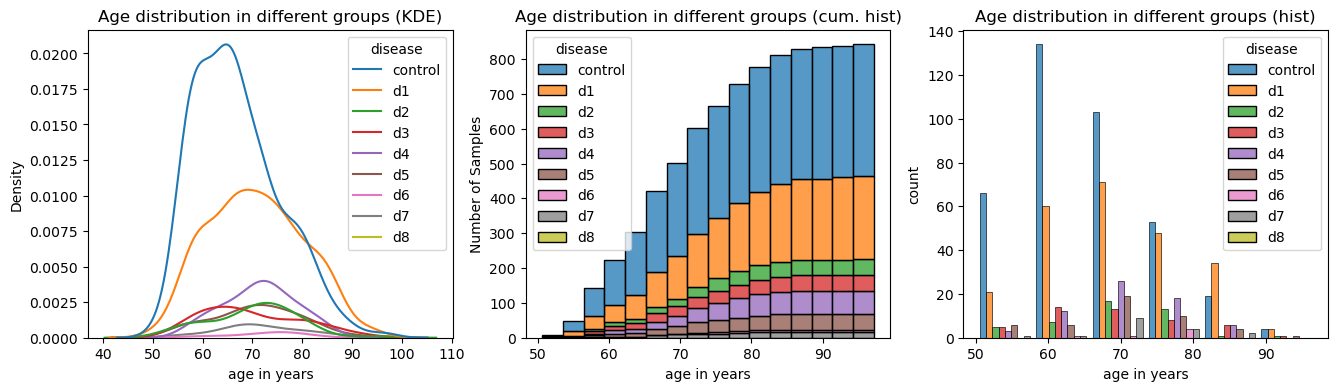

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=[16,4])
sns.kdeplot(data=df, x='age', hue='disease', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'], ax=ax[0])
ax[0].set_title("Age distribution in different groups (KDE)")
ax[0].set_xlabel("age in years")

sns.histplot(data=df, x='age', hue='disease', cumulative=True, multiple='stack', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'], ax=ax[1])
ax[1].set_ylabel("Number of Samples")
ax[1].set_xlabel("age in years")
ax[1].set_title("Age distribution in different groups (cum. hist)")

# histplot nach alter
sns.histplot(data=df, x='age', hue='disease', bins=6, multiple='dodge', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'], ax=ax[2])
ax[2].set_ylabel("count")
ax[2].set_xlabel("age in years")
ax[2].set_title("Age distribution in different groups (hist)")
#p.yaxis.grid(True) 

fig.savefig(f'{dir_plots}age distribution per group')

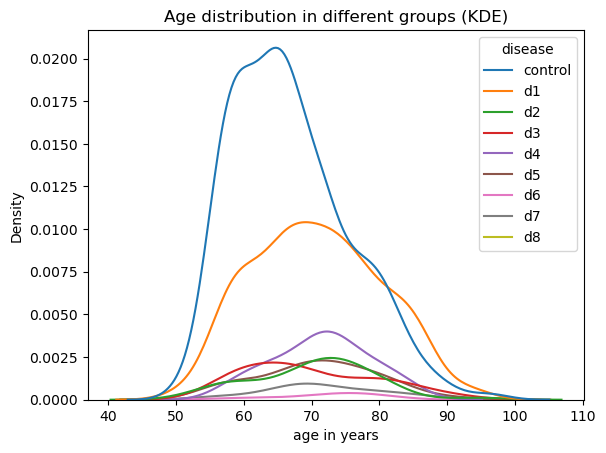

In [20]:
sns.kdeplot(data=df, x='age', hue='disease', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.title("Age distribution in different groups (KDE)")
plt.xlabel("age in years")
plt.savefig(f'{dir_plots}KDE age')

BMI

In [21]:
st_dev_BMI = df.groupby('disease')['bmi'].agg(['mean', 'std', 'min', 'max']) # for mean and std deviation
st_dev_BMI

,mean,std,min,max
disease,,,,
control,26.134631,4.011773,17.087444,44.077133
d1,28.511643,4.930234,18.144869,48.674961
d2,28.617814,4.356346,19.159828,39.183674
d3,26.839059,4.043455,17.998163,37.618412
d4,29.742795,4.969021,19.723866,42.666668
d5,29.501451,6.631926,17.301039,45.165417
d6,26.817510,3.482822,23.999458,33.714882
d7,32.342546,7.444192,23.795361,48.406181


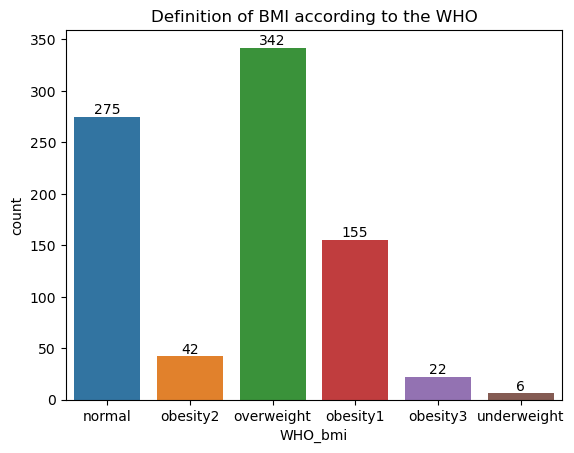

In [22]:
underweight = 18.5
normal = 25
overweight = 30
obesity1 = 35
obesity2 = 40
df['bmi'].round(1).value_counts()

conditions = [
    (df["bmi"] <= underweight),
    (df["bmi"] > underweight) & (df["bmi"] <= normal),
    (df["bmi"] > normal) & (df["bmi"] <= overweight),
    (df["bmi"] > overweight) & (df["bmi"] <= obesity1),
    (df["bmi"] > obesity1) & (df["bmi"] <= obesity2),
    (df["bmi"] > obesity2),
]

bmi_tab = ["underweight", "normal", "overweight", "obesity1", "obesity2", "obesity3"]
#behaviour = [1,2,3,4]
df["WHO_bmi"] = np.select(conditions, bmi_tab)

plt.figure()
ax = sns.countplot(data=df, x="WHO_bmi")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Definition of BMI according to the WHO")
plt.savefig(f'{dir_plots}BMI_who (bar)')

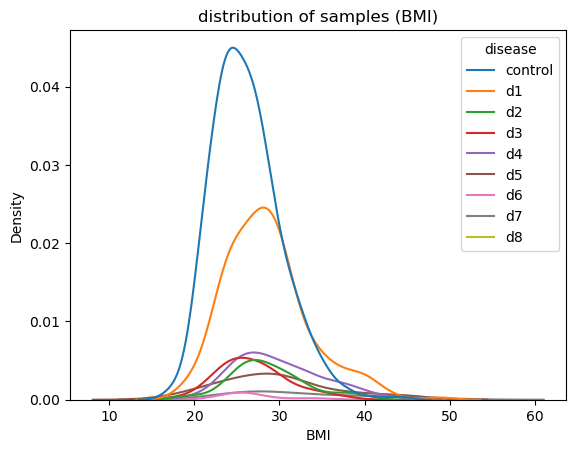

In [23]:
sns.kdeplot(data=df, x='bmi', hue='disease', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.title("distribution of samples (BMI)")
plt.xlabel("BMI")
plt.savefig(f'{dir_plots}KDE plot distribution BMI')

Country of origion

In [24]:
count_origin = (
    df.groupby('disease')
.country
.value_counts()
.unstack()
)
count_origin

,Germany,Sweden,Spain,Italy,France,Denmark,Belgium,Czech Republic,Poland,Slovenia
disease,,,,,,,,,,
control,49,27,41,32,38,22,44,39,45,42
d1,33,29,16,22,18,8,16,27,31,38
d2,6,2,3,2,2,1,7,6,9,6
d3,7,2,3,2,10,4,5,5,9,0
d4,12,5,3,3,4,0,1,10,17,10
d5,8,3,1,5,4,1,5,9,8,2
d6,0,1,0,0,1,0,1,1,1,1
d7,1,1,0,1,0,0,1,7,6,0


In [25]:
print(df["country"].value_counts(normalize=True).mul(100).round(1).astype(str) )

Poland            15.0
Germany           13.8
Czech Republic    12.4
Slovenia          11.8
Belgium            9.5
France             9.1
Sweden             8.3
Spain              8.0
Italy              8.0
Denmark            4.3
Name: country, dtype: object


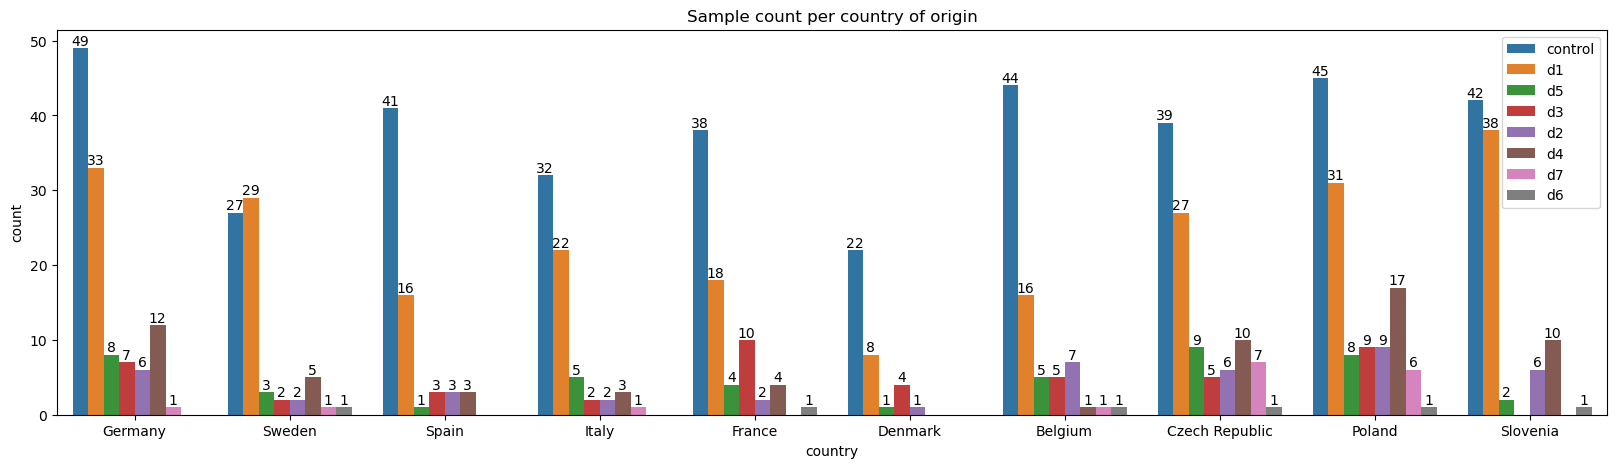

In [26]:
fig, ax = plt.subplots(figsize=(20, 5))

ax = sns.countplot(data=df, x="country", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(loc='upper right')
plt.title("Sample count per country of origin")
plt.savefig(f'{dir_plots}distribution country (bar plot)')

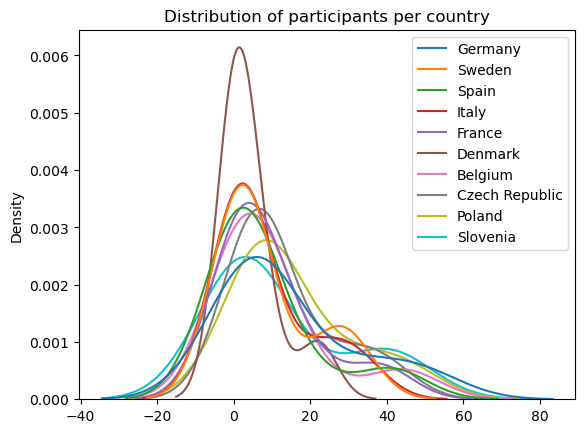

In [27]:
sns.kdeplot(data=count_origin)
plt.title("Distribution of participants per country")
plt.savefig(f'{dir_plots} KDE country')

Oxford covid regulations

In [28]:
covid_count = (
    df.groupby('disease')
.OxCGRT_stay_at_home
.value_counts()
)
covid_perc = (
    df.groupby('disease')
.OxCGRT_stay_at_home
.value_counts(normalize=True).mul(100).round(1).astype(str)
)

covid= pd.concat([covid_count,covid_perc],keys=['counts','%']).unstack()
covid.T

counts                                   %                    \
disease         control   d1  d2  d3  d4  d5 d6  d7 control    d1    d2    d3   
No restrictions     349  215  40  42  61  41  5  17    92.1  90.3  90.9  89.4   
Stay at home         10   11   1   1   0   1  0   0     2.6   4.6   2.3   2.1   
Essential only       20   12   3   4   4   4  1   0     5.3   5.0   6.8   8.5   

                                          
disease            d4    d5    d6     d7  
No restrictions  93.8  89.1  83.3  100.0  
Stay at home      0.0   2.2   0.0    0.0  
Essential only    6.2   8.7  16.7    0.0

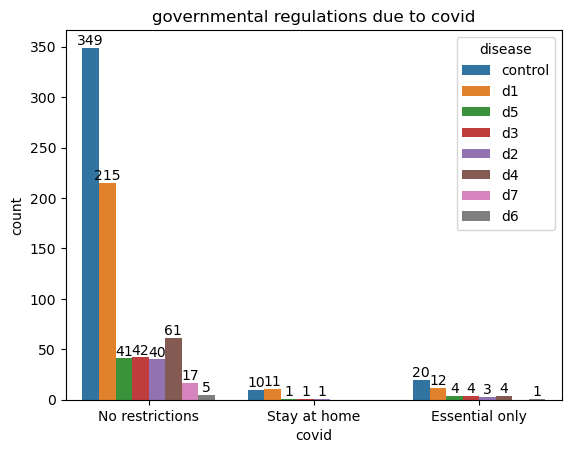

In [29]:
data = pd.DataFrame({
    "covid": df["OxCGRT_stay_at_home"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, x="covid", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("governmental regulations due to covid")
plt.savefig(f'{dir_plots} OxCGRT parameter')

Self-reported activity level

In [30]:
conditions = [
    (df["activity"] == 0) | (df["activity"] == 1),
    (df["activity"] == 2) | (df["activity"] == 3),
    (df["activity"] == 4) | (df["activity"] == 5) | (df["activity"] == 6) | (df["activity"] == 7),
    (df["activity"] == 8) | (df["activity"] == 9),
]

level =["very low", "moderately low", "moderately high", "high"]
df["activ_level"] = np.select(conditions, level)
df["activ_level"].fillna(0)

activ_count = (
    df.groupby('disease')
.activ_level
.value_counts()
)

activ_perc = (
    df.groupby('disease')
.activ_level
.value_counts(normalize=True).mul(100).round(1).astype(str)
)
activ = pd.concat([activ_count, activ_perc], keys=['counts','%']).unstack()
activ.T

counts                                   %                    \
disease         control  d1  d2  d3  d4  d5   d6 d7 control    d1    d2    d3   
activ_level                                                                     
high                127  70  12  14  12  15  NaN  4    33.5  29.4  27.3  29.8   
moderately high      97  58   9  10  16   7    3  1    25.6  24.4  20.5  21.3   
moderately low      119  71  18  15  24  17    2  9    31.4  29.8  40.9  31.9   
very low             36  39   5   8  13   7    1  3     9.5  16.4  11.4  17.0   

                                         
disease            d4    d5    d6    d7  
activ_level                              
high             18.5  32.6   NaN  23.5  
moderately high  24.6  15.2  50.0   5.9  
moderately low   36.9  37.0  33.3  52.9  
very low         20.0  15.2  16.7  17.6

In [31]:
#sns.kdeplot(data=activ)
#plt.savefig(f'{dir_plots} activity score (KDE)')